# Concepts

GARCH stands for "Generalized AutoRegressive Conditional Heteroskedasticity", and it is a popular approach to model volatility. Its based on https://campus.datacamp.com/courses/garch-models-in-python/

## What is volatility ?


In finance, volatility is a statistical measure of the dispersion of asset returns over time. It is often computed as the standard deviation or variance of price returns. We will use the term "volatility" to describe standard deviation or variance interchangeably. Volatility describes uncertainties surrounding the potential price movement of financial assets. 

It is an essential concept widely used in risk management, portfolio optimization, and more. And it has been one of the most active areas of research in empirical finance and time series analysis. In general, the higher the volatility, the riskier a financial asset.


### How to compute volatility?

We can compute the volatility as the standard deviation of price returns following three easy steps. 

* Step 1 is to calculate the returns as percentage price changes.
* Step 2 is to calculate the sample mean return of a chosen n-period.
* Step 3 is to derive the sample standard deviation. 

Also recall standard deviation is the square root of variance.

### Volatility conversion

Assume we measure volatility as the standard deviation of returns, then monthly volatility can be obtained by multiplying daily volatility by the square root of 21, which is the average number or trading days in a month. 

Similarly, annual volatility can be obtained by multiplying daily volatility by the square root of 252, which is the average number or trading days in a year.

### The Challenge

A common assumption in time series modeling is that volatility remains constant over time. However, heteroskedasticity, literally means "different dispersion" in ancient Greek, is frequently observed in financial return data. Volatility tends to increase or decrease systematically over time.

## ARCH & GARCH

Before GARCH, first came the ARCH models. ARCH stands for "Auto-Regressive Conditional Heteroskedasticity", and was developed by American economist Robert F. Engle in 1982. Here "conditional heteroscedasticity" means the data has time-dependent varying characteristic and unpredictable. Due to his contribution, Engle won the Nobel prize in economics in 2003.

Based on ARCH, GARCH models were developed by Danish economist Tim Bollerslev in 1986. The "G" in GARCH stands for "Generalized". Fun fact: Bollerslev wrote about the GARCH models in his Ph.D thesis, under the supervision of Engle, who was the inventor of ARCH models.

### White Noise

A time series is white noise if the variables are independent and identically distributed with a mean of zero. A residual is the difference between the observed value of a variable at time t and its predicted value based on information available prior to time t. 

If the prediction model is working properly, successive residuals are uncorrelated with each other, that is, they constitute a white noise time series. 

In other words, the model has taken care of all the predictable components of a time series, left only the unpredictable white noise part.

### GARCH(1,1) parameter constraints

To make a GARCH(1,1) process realistic, there are two conditions. First, it requires all the parameters, omega, alpha, and beta, to be non-negative. This ensures the variance can't be negative. Second, alpha plus beta should be less than one, which ensures the model estimated variance is always "mean-reverting" to the long-run variance. The long-run variance equals to omega divided by one minus alpha minus beta.

### GARCH(1,1) parameter dynamics

The rule of thumb regarding model parameter is: the larger the alpha, the bigger the immediate impact of the shocks. Here the shocks are expressed as residuals, or prediction errors. If we keep the alpha fixed, the larger the beta, the longer the duration of the impact, that is, high or low volatility periods tend to persist.

## Dataset & Libs

In [1]:
import pandas as pd
import numpy as np
import statsmodels.tsa.stattools as tsa
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import warnings
import math
import datetime as dt
import statsmodels.stats.api as sms
import arch.data.sp500

data = arch.data.sp500.load()
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace import sarimax
from sklearn.metrics import mean_squared_error
from arch import arch_model
from arch.univariate import ARX
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices


sns.set_style('darkgrid')
warnings.filterwarnings("ignore")

In [2]:
def read_datasets():
    df = create_index_datatime(pd.read_csv('itausa.csv',';'))#create_index_datatime()
    df = df.interpolate()                                                 
    return df

def create_index_datatime(df):
    
    format = '%Y-%m-%d'
    
    df['data'] = pd.to_datetime(df['data'],format=format).dt.date
    df['anoMes'] = pd.to_datetime(df['data'],format=format).dt.strftime('%Y-%m')
    
    df = df.set_index('data')
    
    return df

## Stats Func Test

In [3]:
def adf_test(dataset, log_test = False):
    ds = dataset
    
    if log_test:
        ds = np.log(ds)
        ds.dropna(inplace=True)
    
    alpha = 0.05
    
    result = tsa.adfuller(ds)
    print('Augmented Dickey-Fuller Test')
    print('test statistic: %.10f' % result[0])
    print('p-value: %.10f' % result[1])
    print('critical values')
    
    for key, value in result[4].items():
        print('\t%s: %.10f' % (key, value))
        
    if result[1] < alpha:  #valor de alpha é 0.05 ou 5 %
        print("Rejeitamos a Hipotese Nula")
    else:
        print("Aceitamos a Hipotese Nula")

In [4]:
def normal_distribution_test(residual):
    print("\n normal_distribution_test \n ")
    print('p value of Jarque-Bera test is: ', stats.jarque_bera(residual)[1])
    print('p value of Shapiro-Wilk test is: ', stats.shapiro(residual)[1])
    print('p value of Kolmogorov-Smirnov test is: ', stats.kstest(residual, 'norm')[1])
    return

In [5]:
def heteroscedasticity_test(results):
    print("\n heteroscedasticity_test \n ")
    print('p value of Breusch–Pagan test is: ', sms.het_breuschpagan(results.resid, results.model.exog)[1])
    #print('p value of White test is: ', sms.het_white(results.resid, results.model.exog)[1])
    return

In [6]:
def varianceInflationFactor_test(df, target,exog):

    features = "+".join(df[exog].columns)
    print(features)
    
    t_target = target.join(" ~")
    
    y, X = dmatrices(t_target + features, df, return_type='dataframe')
    
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = [target]+exog
    
    return vif

In [7]:
def print_corr(df,titulo):

    mask = np.triu(np.ones_like(df, dtype=bool))

    f, ax = plt.subplots(1,figsize=(10, 8))

    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    sns.heatmap(df, cmap=cmap, vmax=.9, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    ax.set(Title=titulo)

    plt.show()

## Model Functions

In [8]:
def get_model_metrics(actual, forecast):
    
    rmse = np.sqrt(mean_squared_error(actual,forecast))
                
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
                
    num = 0
    den = actual.sum()
    for i in range(len(actual)):
        num = num + abs(actual[i]-forecast[i])
    wmape = 1 - num.sum()/den
    
    return rmse, mape, wmape

    
    # 1 - quando usamos todos os dados para ajustar o modelo, a estimativa do modelo
    #tem viés de lookback. Na realidade, não sabemos o futuro, os dados da serie temporal usados
    # para o ajuste do modelo e a previsão não devem se sobrepor.
    
    #2 - Esta abordagem esta menos sujeita a overfitting (sobreajuste). Uma suposição de modelagem
    # de series temporais é que os parametros do modelo são estaveis ao longo do tempo.
    #Mas isso não é verdade em um ambiente de mercado turbulento.
    
    #3 - Pode adaptar melhor a previsão a possiveis mudanças. Ao incorporar continuamente
    # novas observações ao ajuste e preivsão do modelo, estamos mais abertos as condições
    # do mercado como noticias, ciclos economicos etc.


In [9]:
def expanding_rw_forecast(model, df, start_loc,end_loc,n):
    forecasts = {}

    for i in range(n):
        # Specify fixed rolling window size for model fitting
        v_result = model.fit(first_obs = start_loc, 
                                 last_obs = i + end_loc, disp="off")
        
        # Conduct 1-period variance forecast and save the result
        temp_result = v_result.forecast(horizon = 1).variance
        fcast = temp_result.iloc[i + end_loc]
        forecasts[fcast.name] = fcast
    
    # Save all forecast to a dataframe    
    forecast_var = pd.DataFrame(forecasts).T
    
    # Plot the forecast variance
    plt.plot(forecast_var, color = 'red')
    plt.plot(df[end_loc:end_loc+n], color = 'green')
    plt.show()
    
    return forecast_var

In [10]:
def fixed_rw_forecast(model, df, start_loc,end_loc,n):
    # Neste metodo, os pontos de dados antigos são eliminados da amostra
    # simultaneamente para manter um tamanho de janela fixa
    
    forecasts = {}

    for i in range(n):
        # Specify fixed rolling window size for model fitting
        v_result = model.fit(first_obs = i + start_loc, 
                                 last_obs = i + end_loc, disp="off")
        
        # Conduct 1-period variance forecast and save the result
        temp_result = v_result.forecast(horizon = 1).variance

        fcast = temp_result.iloc[i + end_loc]
        forecasts[fcast.name] = fcast
    
    # Save all forecast to a dataframe    
    forecast_var = pd.DataFrame(forecasts).T
    
    # Plot the forecast variance
 
    plt.plot(forecast_var, color = 'red')
    plt.plot(df[end_loc:end_loc+n], color = 'green')
    plt.show()
    
    return forecast_var

In [11]:
def get_arx_model(name,y,exog, lags):
    x=exog
    
    mod = arch_model(y,mean=name, lags=lags,dist="StudentsT")
    res = mod.fit(disp="off")
    print(res.summary())
    
    return mod,res

In [12]:
def get_arch_model(df, p, o, q, mean, type_model, dist):
    
    #split_date = dt.date(2021,5,1)
    model = arch_model(df, p=p, o=o, q = q, mean=mean,vol=type_model,dist=dist)
    
    model_fit = model.fit(update_freq = 5)#last_obs=split_date
    
    print ("\n\n Model \n",model_fit.summary()) 
    #f, axes = plt.subplots(1, figsize=(15,5))
    model_fit.plot()
    plt.show()
    
    return model_fit, model #[-1:]

## Read Data

In [13]:
itausa = read_datasets()

In [14]:
sp500 = arch.data.sp500.load()
market = sp500["Adj Close"]
sp500["returns"] = 100 * market.pct_change().dropna()

In [95]:
itausa_train = itausa[0:1000]
itausa_test = itausa[1000:] #295

In [96]:
itausa_train.head()

,year,month,last,open,max,min,Covid,anoMes,return_data,volatility
data,,,,,,,,,,
2016-01-04,2016,1,4.22,4.35,4.37,4.22,0,2016-01,NaN,2.064335
2016-01-05,2016,1,4.29,4.28,4.31,4.23,0,2016-01,1.658768,2.064335
2016-01-06,2016,1,4.33,4.23,4.41,4.21,0,2016-01,0.932401,2.064335
2016-01-07,2016,1,4.27,4.25,4.31,4.21,0,2016-01,-1.385681,2.064335
2016-01-08,2016,1,4.27,4.31,4.34,4.24,0,2016-01,0.000000,2.064335


In [17]:
sp500.tail()

,Open,High,Low,Close,Adj Close,Volume,returns
Date,,,,,,,
2018-12-24,2400.560059,2410.340088,2351.100098,2351.100098,2351.100098,2613930000,-2.711225
2018-12-26,2363.120117,2467.760010,2346.580078,2467.699951,2467.699951,4233990000,4.959374
2018-12-27,2442.500000,2489.100098,2397.939941,2488.830078,2488.830078,4096610000,0.856268
2018-12-28,2498.770020,2520.270020,2472.889893,2485.739990,2485.739990,3702620000,-0.124158
2018-12-31,2498.939941,2509.239990,2482.820068,2506.850098,2506.850098,3442870000,0.849248


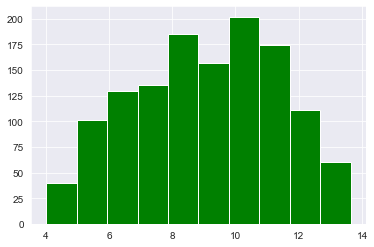

In [18]:
plt.hist(itausa['last'], facecolor = 'green',label='Dist Last')
plt.show()

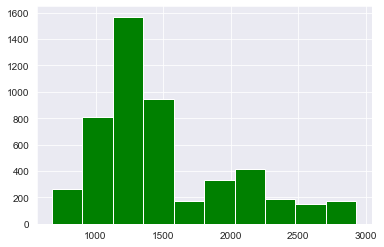

In [19]:
plt.hist(sp500["Adj Close"], facecolor = 'green',label='Dist Last')
plt.show()

### Correlation

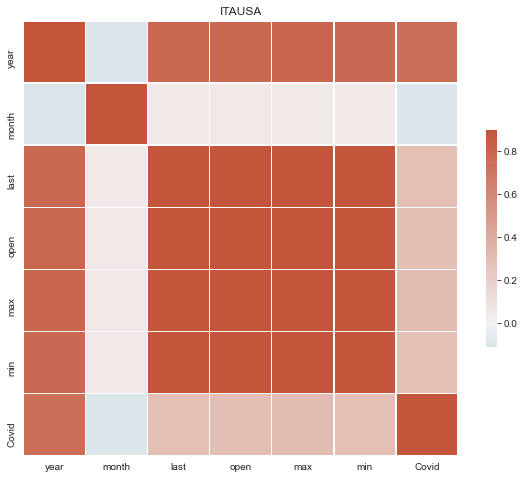

In [20]:
itausa_corr = itausa.corr()

print_corr(itausa_corr,"ITAUSA")

### Stationary Test

In [21]:
adf = adf_test(itausa['last'].diff().dropna())

Augmented Dickey-Fuller Test
test statistic: -12.9157560026
p-value: 0.0000000000
critical values
	1%: -3.4354412127
	5%: -2.8637883403
	10%: -2.5679670339
Rejeitamos a Hipotese Nula


### Observe volatility clustering

Volatility clustering is frequently observed in financial market data, and it poses a challenge for time series modeling.

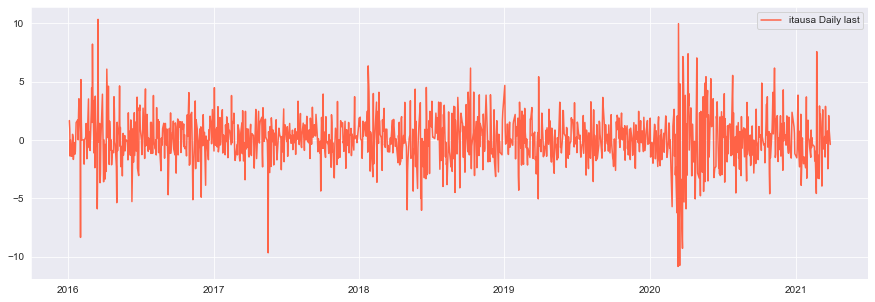

In [22]:
itausa['return_data'] = 100 * itausa['last'].pct_change()
itausa['volatility'] = itausa['return_data'].std()

f, axes = plt.subplots(1, figsize=(15,5))
plt.plot(itausa['return_data'], color = 'tomato', label = 'itausa Daily last')
plt.legend(loc='upper right')
plt.show()

In [23]:
std_daily = itausa['return_data'].std()
print('Daily volatility: ', '{:.2f}%'.format(std_daily))

Daily volatility:  2.06%


In [24]:
std_daily = sp500['returns'].std()
print('Daily volatility: ', '{:.2f}%'.format(std_daily))

Daily volatility:  1.20%


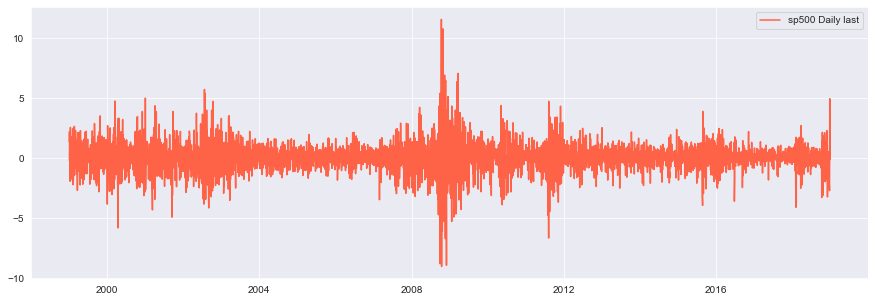

In [25]:
f, axes = plt.subplots(1, figsize=(15,5))
plt.plot(sp500['returns'], color = 'tomato', label = 'sp500 Daily last')
plt.legend(loc='upper right')
plt.show()

## Arch Model

Iteration:      5,   Func. Count:     32,   Neg. LLF: 1978.4385570483398
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1978.434723939168
            Iterations: 8
            Function evaluations: 46
            Gradient evaluations: 8


 Model 
                          Constant Mean - ARCH Model Results                         
Dep. Variable:                  return_data   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                             ARCH   Log-Likelihood:               -1978.43
Distribution:      Standardized Student's t   AIC:                           3964.87
Method:                  Maximum Likelihood   BIC:                           3984.50
                                              No. Observations:                  999
Date:                      Thu, Jun 17 2021   Df Residuals:                      995
Time:                        

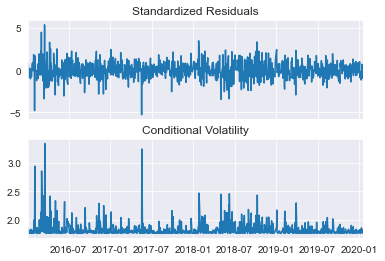

In [97]:
p = 1
o = 0
q = 1
mean = 'constant' #'zero', 'AR', 'constant'
type_model = 'ARCH' #'GARCH','ARCH', 'EGARCH'
dist = 't' #'t','skewt','normal'


arch_fit, arch_mod = get_arch_model(itausa_train['return_data'].dropna(),p , o, q, mean, type_model,dist)

In [31]:
para_summary = pd.DataFrame({'parameter':arch_fit.params,
                             'p-value': arch_fit.pvalues,
                             't-value': arch_fit.tvalues,
                             'Log-likelihood': arch_fit.loglikelihood,
                             'AIC':arch_fit.aic,
                             'BIC':arch_fit.bic})
para_summary

,parameter,p-value,t-value,Log-likelihood,AIC,BIC
mu,0.085105,7.816096e-02,1.761458,-2681.248254,5370.496508,5391.158482
omega,3.230525,6.428753e-45,14.062804,-2681.248254,5370.496508,5391.158482
alpha[1],0.234026,5.405216e-06,4.548412,-2681.248254,5370.496508,5391.158482
nu,5.562762,1.534738e-12,7.071314,-2681.248254,5370.496508,5391.158482


## GARCH Model

Iteration:      5,   Func. Count:     36,   Neg. LLF: 1966.2084001574362
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1966.2067992100415
            Iterations: 8
            Function evaluations: 50
            Gradient evaluations: 8


 Model 
                           Zero Mean - GARCH Model Results                           
Dep. Variable:                  return_data   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.001
Vol Model:                            GARCH   Log-Likelihood:               -1966.21
Distribution:      Standardized Student's t   AIC:                           3940.41
Method:                  Maximum Likelihood   BIC:                           3960.04
                                              No. Observations:                  999
Date:                      Thu, Jun 17 2021   Df Residuals:                      995
Time:                       

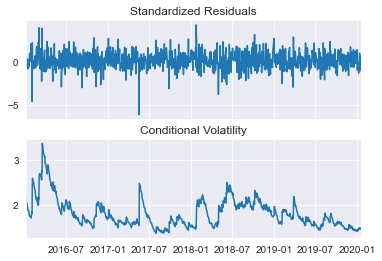

In [98]:
p = 1
o = 0
q = 1
mean = 'Zero' #'zero', 'AR', 'constant'
type_model = 'GARCH' #'GARCH','ARCH', 'EGARCH' garch
dist = 't' #'t','skewt','normal'

garch_fit, garch_mod = get_arch_model(itausa_train['return_data'].dropna(),p,o,q, mean,type_model,dist)

The null hypothesis is the parameter value is zero. If the p-value is larger than a given confidence level, the null hypothesis cannot be rejected, meaning the parameter is not statistically significant, hence not necessary.

Besides p-values, t-statistics can also help decide the necessity of model parameters. 

The t-statistic is computed as the estimated parameter value subtracted by its expected mean, and divided by its standard error. The absolute value of the t-statistic is a distance measure, that tells you how many standard errors the estimated parameter is away from 0. As a rule of thumb, if the t-statistic is larger than 2, you can reject the null hypothesis.

In [29]:
temp_result = garch_fit.forecast(horizon = 7)
temp_result.variance.values[-1, :]

array([3.66774889, 3.68153863, 3.69492502, 3.70791987, 3.72053464,
       3.73278043, 3.74466803])

In [30]:
para_summary = pd.DataFrame({'parameter':garch_fit.params,
                             'p-value': garch_fit.pvalues,
                             't-value': garch_fit.tvalues,
                             'Log-likelihood': garch_fit.loglikelihood,
                             'AIC':garch_fit.aic,
                             'BIC':garch_fit.bic})
para_summary

,parameter,p-value,t-value,Log-likelihood,AIC,BIC
omega,0.121069,3.491980e-02,2.109287,-2644.461846,5296.923692,5317.585666
alpha[1],0.070642,6.764349e-04,3.398956,-2644.461846,5296.923692,5317.585666
beta[1],0.900109,8.267463e-190,29.386098,-2644.461846,5296.923692,5317.585666
nu,6.621153,3.905842e-09,5.888132,-2644.461846,5296.923692,5317.585666


## Compare Models

### Residual

In [34]:
garch_resid = garch_fit.resid
garch_std = garch_fit.conditional_volatility
garch_std_resid = garch_resid/garch_std

arch_resid = arch_fit.resid
arch_std = arch_fit.conditional_volatility
arch_std_resid = arch_resid/arch_std

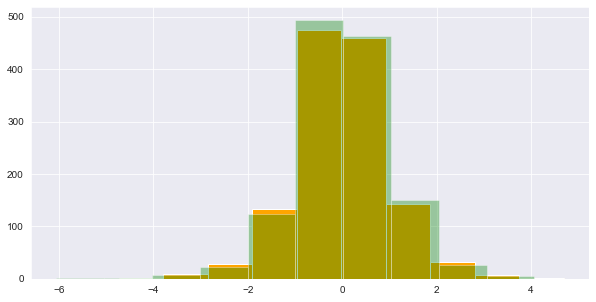

In [41]:
# Plot the histogram of the standardized residuals
f, axes = plt.subplots(1, figsize=(10,5))
plt.hist(arch_std_resid, facecolor = 'orange', label = 'arch Standardized residuals')
plt.hist(garch_std_resid, facecolor = 'green',alpha = 0.35, label = 'garch Standardized residuals')

plt.show()

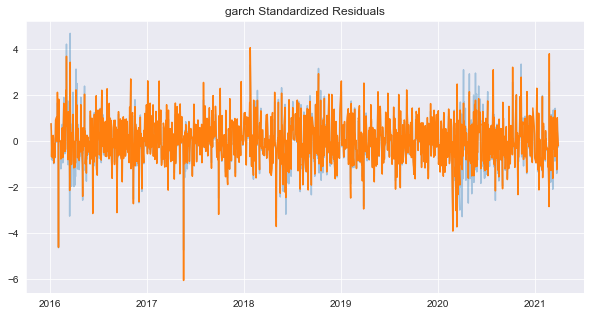

In [48]:
f, axes = plt.subplots(1, figsize=(10,5))

plt.plot(arch_std_resid, alpha=0.35)
plt.plot(garch_std_resid)
plt.title('garch Standardized Residuals')
plt.show()

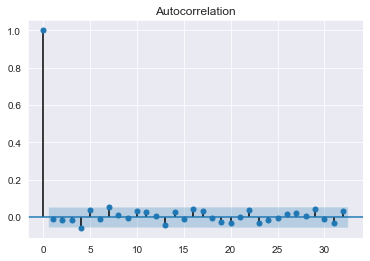

In [49]:
# Generate ACF plot of the standardized residuals
plot_acf(garch_std_resid, alpha = 0.05)
plt.show()

Another powerful tool to check autocorrelations in the data is the Ljung-Box test.

The null hypothesis of Ljung-Box test is: 

* The data is independently distributed. If the p-value is larger than the specified significance level, the null hypothesis cannot be rejected. 
* In other words, there is no clear sign of autocorrelations and the model is valid.

In [ ]:
# Perform the Ljung-Box test
lb_test = acorr_ljungbox(itausa_std_resid , lags = 10)

# Print the p-values
print('P-values are: ', lb_test[1])

In [ ]:
f, axes = plt.subplots(1, figsize=(10,5))
# Plot the actual Bitcoin returns
plt.plot(itausa['return_data'], color = 'grey', alpha = 0.4, label = 'Price Returns')

# Plot GARCH estimated volatility
plt.plot(model_fit.conditional_volatility, color = 'gold', label = 'GARCH Volatility')

# Plot ARCH estimated volatility
plt.plot(arch_fit.conditional_volatility, color = 'red',alpha = 0.4, label = 'ARCH Volatility')

plt.show()

### Rolling window forecast

**Expanding window forecast**

There are mainly two ways to perform a rolling window forecast. One is "expanding window" approach, which starts with a set of sample data, and as time moves forward, continuously adds new data points to the sample. 

Suppose we have 200 observations of a time-series. 

First, we estimate the model with the first 100 observations to forecast the data point 101. Then we include observation 101 into the sample, and estimate the model again to forecast the data point 102. 

The process is repeated until we have forecast for all 100 out-of-sample data points.


Rolling window forecast is widely used because of the following motivations: 

* First, when we use all the data to fit a model, the model estimation has lookback bias. In reality, we do not know the future, so the time series data used for model fitting and forecast should not overlap. 

* Second, the rolling window approach is less subject to overfitting. An implicit time series modeling assumption is model parameters are stable over time. But this barely holds true in turbulent market environment. Imagine when we try to fit a GARCH(1,1) with observations from economic crisis versus normal market conditions, we are likely to obtain very different omega, alpha, beta results. 

* Third, the rolling window approach can better adapt our forecast to changes. By continuously incorporating new observations to the model fitting and forecast, we are more responsive to the most recent economic conditions, such as news, changes in economic cycles, etc.

**Fixed rolling window forecast**

Another rolling window forecast method is call "fixed rolling window forecast". Similarly it starts with a set of sample data, and as time moves forward, new data points are added. What different is old data points are dropped from the sample simultaneously to maintain a fixed window size.

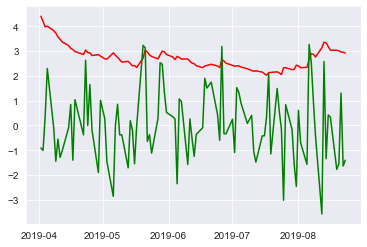

In [117]:
start_loc = 200
end_loc = 800
window = 100

variance_expandwin = expanding_rw_forecast(garch_mod,itausa_train['return_data'].dropna(),start_loc,end_loc,window)

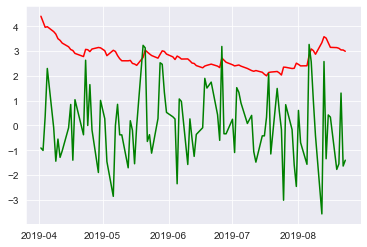

In [118]:
variance_fixedwin = fixed_rw_forecast(garch_mod,itausa_train['return_data'].dropna(),start_loc,end_loc,window)

As you can see the model did a decent job: variance predicted by our model fluctuates with the actual returns.

### Compare forecast results

In [119]:
# Print top 5 rows of variance forecast with an expanding window
variance_expandwin.head()

,h.1
2019-04-02,4.405419
2019-04-03,4.197319
2019-04-04,3.979404
2019-04-05,4.005186
2019-04-08,3.824513


In [121]:
# Print top 5 rows of variance forecast with a fixed rolling window
variance_fixedwin.head()

,h.1
2019-04-02,4.405419
2019-04-03,4.184637
2019-04-04,3.958274
2019-04-05,3.982828
2019-04-08,3.785691


In [122]:
# Calculate volatility from variance forecast with an expanding window
vol_expandwin = np.sqrt(variance_expandwin)
# Calculate volatility from variance forecast with a fixed rolling window
vol_fixedwin = np.sqrt(variance_fixedwin)

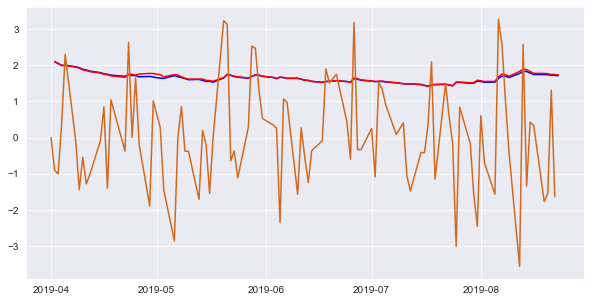

In [123]:
f, axes = plt.subplots(1, figsize=(10,5))
# Plot volatility forecast with an expanding window
plt.plot(vol_expandwin, color = 'blue')
# Plot volatility forecast with a fixed rolling window
plt.plot(vol_fixedwin, color = 'red')
plt.plot(itausa['return_data'][end_loc:end_loc+window], color = 'chocolate')
plt.show()

## Compute parametric VaR


### What is VaR?

VaR stands for "Value at Risk". It is an important concept in risk management to quantify the potential losses. VaR is always discussed with three ingredients: a portfolio, a time horizon and a probability. VaR value indicates given a time horizon, the portfolio is likely to lose at least this much money given a specified probability.

For example, a 1-day 5% VaR of one million dollars means there is a 5% probability the portfolio will fall in value by 1 million dollars or more over a 1-day period. Likewise, a 10-day 1% VaR of $9 million means there is a 1% probability the portfolio will fall in value by 9 million dollars or more over a 10-day period. This can also be phrased as over the 10-day period, there is a 99% probability the portfolio will lose less than 9 million dollars.

**In financial risk management, VaR is designed to gauge potential portfolio losses and set risk limits. When the portfolio loss exceeds the VaR, it is called a VaR exceedance.** 

In [211]:
def var_potential(forecast,itausa_test):
    
    arch_mean = forecast.mean.values[-1, :]
    mean = pd.DataFrame(arch_mean, columns=["mean"])
    print("\nMean",mean.head())
    
    arch_variance = forecast.variance.values[-1, :]
    variance = pd.DataFrame(arch_variance, columns=["variance"])
    print("\nVariance",variance.head())
    
    nu = [arch_fit.params[-2:][1]]
    print("\nnu(degree of freedom)",nu)
    
    # Obtain the parametric quantile
    q_parametric = arch_mod.distribution.ppf(0.05, nu)

    # Calculate the VaR
    VaR_parametric = mean.values + np.sqrt(variance).values * q_parametric
    # Save VaR in a DataFrame
    VaR_parametric = pd.DataFrame(VaR_parametric, columns = ['5%'], index=itausa_test.index)
    print("\nVaR_parametric",VaR_parametric.head())
    
    
    # Plot the VaR
    f, axes = plt.subplots(1, figsize=(10,5))
    plt.plot(VaR_parametric, color = 'red', label = '5% Parametric VaR')
    plt.scatter(itausa_test.index,itausa_test['return_data'], color = 'orange', label = 'Itausa Daily Returns' )
    plt.legend(loc = 'upper right')
    plt.show()
    
    
    return VaR_parametric

##### Arch


Mean        mean
0  0.121678
1  0.121678
2  0.121678
3  0.121678
4  0.121678

Variance    variance
0  3.132701
1  3.341814
2  3.358014
3  3.359269
4  3.359366

nu(degree of freedom) [5.3458844714404785]

VaR_parametric                   5%
data                
2020-01-20 -2.660060
2020-01-21 -2.751403
2020-01-22 -2.758359
2020-01-23 -2.758897
2020-01-24 -2.758939


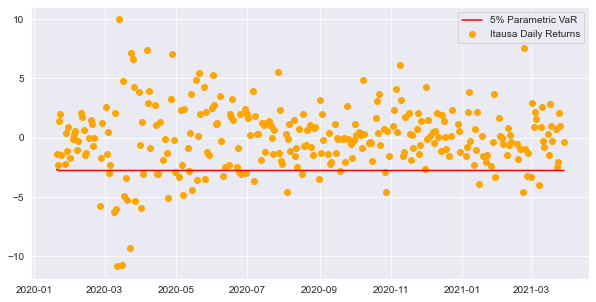

In [214]:
arch_forecast = arch_fit.forecast(horizon=295)
VaR_parametric = var_potential(arch_forecast,itausa_test)

Pay attention to the dots that fell below the VaR threshold. For 5% VaR there are less than n exceedances observed over 1 year, so the model is doing a decent job.

##### Garch


Mean    mean
0   0.0
1   0.0
2   0.0
3   0.0
4   0.0

Variance    variance
0  2.112591
1  2.140064
2  2.166887
3  2.193076
4  2.218644

nu(degree of freedom) [5.3458844714404785]

VaR_parametric                   5%
data                
2020-01-20 -2.284360
2020-01-21 -2.299165
2020-01-22 -2.313529
2020-01-23 -2.327467
2020-01-24 -2.340995


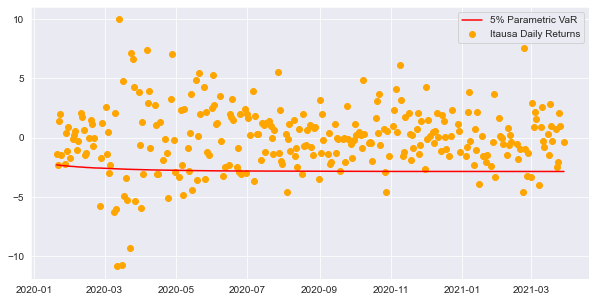

In [213]:
garch_forecast = garch_fit.forecast(horizon = 295)
VaR_parametric = var_potential(garch_forecast,itausa_test)

Pay attention to the dots that fell below the VaR threshold. For 5% VaR there are less than n exceedances observed over 1 year, so the model is doing a decent job.